## Spark RDDs

### Loading data into an RDD

We load the data into an RDD consisting of string elements, each element corresponding to the text of a Wikipedia page. Precisely, each RDD element should be a string equal to the text enclosed within `<page>` and `</page>` XML tags in the input dataset with carriage-return characters (`\n`) removed.

In [1]:
# Wikipedia dump
# we use the enwiki-latest-pages-articles1.xml-p1p41242.bz2 dump
!wget https://dumps.wikimedia.org/enwiki/latest/enwiki-latest-pages-articles1.xml-p1p41242.bz2
# decompress the file
!bzip2 -d enwiki-latest-pages-articles1.xml-p1p41242.bz2
# rename the uncompressed file to an XML format
!mv enwiki-latest-pages-articles1.xml-p1p41242 enwiki-latest-pages-articles1.xml
# move to Hadoop Namenode
!hadoop fs -put enwiki-latest-pages-articles1.xml /

--2024-02-23 14:23:06--  https://dumps.wikimedia.org/enwiki/latest/enwiki-latest-pages-articles1.xml-p1p41242.bz2
Resolving dumps.wikimedia.org (dumps.wikimedia.org)... 208.80.154.71, 2620:0:861:3:208:80:154:71
Connecting to dumps.wikimedia.org (dumps.wikimedia.org)|208.80.154.71|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 276785341 (264M) [application/octet-stream]
Saving to: ‘enwiki-latest-pages-articles1.xml-p1p41242.bz2’

enwiki-latest-pages 100%[===================>] 263.96M  4.29MB/s    in 60s     

2024-02-23 14:24:06 (4.42 MB/s) - ‘enwiki-latest-pages-articles1.xml-p1p41242.bz2’ saved [276785341/276785341]



In [2]:
# adjust to reflect the cluster name and Hadoop masternode (IP port) of your cluster
path = "hdfs://st446-cluster-a01-m:8020/enwiki-latest-pages-articles1.xml"

In [3]:
# initial Dataframe
# pages are separated by <page> and </page>
df1 = spark.read.text(path, lineSep="</page>")
df1.limit(10).toPandas()

,value
0,"<mediawiki xmlns=""http://www.mediawiki.org/xml..."
1,\n <page>\n <title>Anarchism</title>\n ...
2,\n <page>\n <title>AfghanistanHistory</tit...
3,\n <page>\n <title>AfghanistanGeography</t...
4,\n <page>\n <title>AfghanistanPeople</titl...
5,\n <page>\n <title>AfghanistanCommunicatio...
6,\n <page>\n <title>AfghanistanTransportati...
7,\n <page>\n <title>AfghanistanMilitary</ti...
8,\n <page>\n <title>AfghanistanTransnationa...
9,\n <page>\n <title>AssistiveTechnology</ti...


In [4]:
# accessing RDD element attached to the Dataframe
rdd1 = df1.rdd

---

**Additional check** to get a better idea of how the data (RDD) is structured.

In [5]:
# numPartitions depend on the cluster machine being used
# for instance, N2 4 vCPUs will give you 8 partitions
rdd1.getNumPartitions()

8

In [6]:
# first element
rdd1.take(1)

[Row(value='<mediawiki xmlns="http://www.mediawiki.org/xml/export-0.10/" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://www.mediawiki.org/xml/export-0.10/ http://www.mediawiki.org/xml/export-0.10.xsd" version="0.10" xml:lang="en">\n  <siteinfo>\n    <sitename>Wikipedia</sitename>\n    <dbname>enwiki</dbname>\n    <base>https://en.wikipedia.org/wiki/Main_Page</base>\n    <generator>MediaWiki 1.42.0-wmf.18</generator>\n    <case>first-letter</case>\n    <namespaces>\n      <namespace key="-2" case="first-letter">Media</namespace>\n      <namespace key="-1" case="first-letter">Special</namespace>\n      <namespace key="0" case="first-letter" />\n      <namespace key="1" case="first-letter">Talk</namespace>\n      <namespace key="2" case="first-letter">User</namespace>\n      <namespace key="3" case="first-letter">User talk</namespace>\n      <namespace key="4" case="first-letter">Wikipedia</namespace>\n      <namespace key="5" case="first-letter">Wikipedi

In [7]:
# RDD2: all rows containing <page>
rdd2 = rdd1.filter(lambda row: "<page>" in row[0])

In [8]:
# split RDD2 based on <page> and with no carriage returns
rdd2 = rdd2.map(lambda row: row[0].split("<page>")[1].replace("\n", ""))

In [9]:
# first element of RDD2
rdd2.take(1)

['    <title>AccessibleComputing</title>    <ns>0</ns>    <id>10</id>    <redirect title="Computer accessibility" />    <revision>      <id>1002250816</id>      <parentid>854851586</parentid>      <timestamp>2021-01-23T15:15:01Z</timestamp>      <contributor>        <username>Elli</username>        <id>20842734</id>      </contributor>      <minor />      <comment>shel</comment>      <model>wikitext</model>      <format>text/x-wiki</format>      <text bytes="111" xml:space="preserve">#REDIRECT [[Computer accessibility]]{{rcat shell|{{R from move}}{{R from CamelCase}}{{R unprintworthy}}}}</text>      <sha1>kmysdltgexdwkv2xsml3j44jb56dxvn</sha1>    </revision>  ']

In [10]:
# number of elements in RDD2
rdd2.count()

27376

### Number of categories per page

Some Wikipedia pages contain information about categories to which they belong. For those Wikipedia pages, there can be one or more categories indicated in the Wikipedia dump file. We will create a key-value pair RDD with keys corresponding to page IDs and values corresponding to the number of categories of the corresponding page.

In [11]:
def page_id(wikipage):
    start = wikipage.find('<id>') + len('<id>')
    end = wikipage.find('</id>', start)
    if start != -1 and end != -1:
        return wikipage[start:end]
    else:
        return None

In [12]:
def no_of_categories(wikipage):
    category_count = wikipage.count("[[Category:")
    return category_count

In [77]:
c_rdd = rdd2.map(lambda x: (int(page_id(x)), no_of_categories(x))) \
            .filter(lambda x: x[1] > 0) \
            .reduceByKey(lambda x,y: x+y) 
output = c_rdd.takeOrdered(10, lambda k_v: -k_v[1])
output

[(19856, 233),
 (6198, 230),
 (32753, 221),
 (22107, 218),
 (16775, 215),
 (31898, 214),
 (6201, 213),
 (32124, 208),
 (31940, 198),
 (7851, 181)]

### Finding the Top contributors

We will analyse the amount of contributions made by contributors in terms of the number of page revisions.

In [14]:
def contributor_id(wikipage):
    start = wikipage.find('<contributor>')
    end = wikipage.find('</contributor>', start)
    if start != -1 and end != -1:
        start1 = wikipage.find('<id>', start, end) + len('<id>')
        end1 = wikipage.find('</id>', start1, end)
        if start1 != -1 and end1 != -1:
            return wikipage[start1:end1]

In [15]:
def contributor_name(wikipage):
    start = wikipage.find('<username>') + len('<username>')
    end = wikipage.find('</username>', start)
    if start != -1 and end != -1:
        return wikipage[start:end]
    else:
        return None

In [16]:
#key-value pair RDD with keys corresponding to page IDs and the value corresponding to contributor IDs
page_contributor_rdd = rdd2.map(lambda x: (page_id(x), contributor_id(x))) \
                           .map(lambda x: (x[1], 1)) \
                           .reduceByKey(lambda x, y: x + y)

In [17]:
page_contributor_rdd.take(2)

[('32990417', 24), ('41234605', 1)]

In [18]:
#key-value pair RDD with keys corresponding to contributor IDs and values corresponding to contributor names
contributor_name_rdd = rdd2.map(lambda x: (contributor_id(x), contributor_name(x))) \
                           .filter(lambda x: x[0] is not None and x[1] is not None).distinct()

In [19]:
contributor_name_rdd.take(2)

[('20842734', 'Elli'), ('244263', 'Czar')]

In [136]:
#key-value pair RDD with keys corresponding to contributor IDs and values corresponding to a tuple with the first element 
#corresponding to the number of pages revised by the contributor and the second element corresponding to the contributor's name
pair_rdd = page_contributor_rdd.join(contributor_name_rdd) \
                               .map(lambda x: (int(x[0]), (x[1][0], x[1][1])))

output = pair_rdd.sortBy(lambda k_v: -k_v[1][0])
output.take(10)

[(7903804, (1266, 'Citation bot')),
 (9784415, (1204, 'Tom.Reding')),
 (194203, (432, 'Graham87')),
 (20836525, (395, '1234qwer1234qwer4')),
 (212624, (362, 'MZMcBride')),
 (27015025, (355, 'InternetArchiveBot')),
 (27823944, (275, 'GreenC bot')),
 (44120587, (266, 'HeyElliott')),
 (8066546, (232, 'Xqbot')),
 (35936988, (203, 'JJMC89 bot III'))]

Here, we have the top 10 contributors in decreasing order of the number of pages revised by them.

## Spark Dataframes

### Creating a dataframe

We will create a dataframe having the columns pade_id, title, contributor, categories, and revision_ts.

In [21]:
from pyspark.sql.types import StructType, StructField, StringType, LongType, ArrayType, TimestampType, IntegerType
import pyspark.sql.functions as sql_f
from datetime import datetime

In [22]:
def extract_title(wikipage):
    start = wikipage.find('<title>') + len('<title>')
    end = wikipage.find('</title>', start)
    if start != -1 and end != -1:
        return wikipage[start:end]
    else:
        return None

In [23]:
def contributor_id(wikipage):
    start = wikipage.find('<id>', wikipage.find('<contributor>')) + len('<id>')
    end = wikipage.find('</id>', start)
    if start != -1 and end != -1:
        id_str = wikipage[start:end].strip()  #removing leading and trailing whitespace
        try:
            return int(id_str)
        except ValueError:
            return None
    else:
        return None

In [24]:
def extract_categories(wikipage):
    categories = []
    start = 0
    while True:
        start = wikipage.find("[[Category:", start)
        if start == -1:
            break
        end = wikipage.find("]]", start)
        if end != -1:
            categories.append(wikipage[start+len("[[Category:"):end])
            start = end + 1
        else:
            break
    return categories

In [25]:
def extract_revision_ts(wikipage):
    start = wikipage.find('<timestamp>') + len('<timestamp>')
    end = wikipage.find('</timestamp>', start)
    if start != -1 and end != -1:
        revision_ts_str = wikipage[start:end]
        return datetime.strptime(revision_ts_str, "%Y-%m-%dT%H:%M:%SZ")
    else:
        return None

In [86]:
myschema = StructType([
    StructField('page_id', LongType(), True),
    StructField('title', StringType(), True),
    StructField('contributor', StructType([StructField('contributor_id', LongType(), True),
                                            StructField('username', StringType(), True)]), True),
    StructField('categories', ArrayType(StringType()), True),
    StructField('revision_ts', TimestampType(), True)
])

In [91]:
from pyspark.sql import Row

#converting our rdd to an rdd to type Row as its needed for us to be able to use the method createDataFrame
rows = rdd2.map(lambda x: Row(page_id=int(page_id(x)), 
                              title=extract_title(x), 
                              contributor=(contributor_id(x), contributor_name(x)), 
                              categories=extract_categories(x), 
                              revision_ts=extract_revision_ts(x)))

In [92]:
df = spark.createDataFrame(rows, schema=myschema) #creating our dataframe

#### Showing the schema

In [93]:
df.printSchema()

root
 |-- page_id: long (nullable = true)
 |-- title: string (nullable = true)
 |-- contributor: struct (nullable = true)
 |    |-- contributor_id: long (nullable = true)
 |    |-- username: string (nullable = true)
 |-- categories: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- revision_ts: timestamp (nullable = true)



#### Showing the first 10 rows

In [94]:
df.select("page_id", "title", "contributor", "categories", "revision_ts") \
  .show(10, truncate=True, vertical=False)

+-------+--------------------+--------------------+--------------------+-------------------+
|page_id|               title|         contributor|          categories|        revision_ts|
+-------+--------------------+--------------------+--------------------+-------------------+
|     10| AccessibleComputing|    {20842734, Elli}|                  []|2021-01-23 15:15:01|
|     12|           Anarchism|      {244263, Czar}|[Anarchism| , Ant...|2024-02-17 15:33:05|
|     13|  AfghanistanHistory|{9784415, Tom.Red...|                  []|2017-06-05 04:18:18|
|     14|AfghanistanGeography|{9784415, Tom.Red...|                  []|2017-06-05 04:18:23|
|     15|   AfghanistanPeople|{9784415, Tom.Red...|                  []|2017-06-05 04:19:42|
|     18|AfghanistanCommun...|{9784415, Tom.Red...|                  []|2017-06-05 04:19:45|
|     19|AfghanistanTransp...|{9784415, Tom.Red...|                  []|2017-06-04 21:42:11|
|     20| AfghanistanMilitary|    {8066546, Xqbot}|                  [

#### Showing the count of the number of rows

In [95]:
row_count = df.rdd.count()
row_count

27376

#### Showing the number of Dataframe partitions

In [32]:
partitions_count = df.rdd.getNumPartitions()
partitions_count

8

### Page title lengths

We will now compute a Dataframe with the first column corresponding to page ID and the second column corresponding to page title length (in the number of words).

In [33]:
import matplotlib.pyplot as plt
import pandas as pd

In [34]:
def pagetitle_length(title):
    return len(title.split())

In [35]:
#computing a Dataframe with the first column corresponding to page ID and the second column corresponding to 
#page title length (in the number of words).
df_title_length = df.rdd.map(lambda x: (x[0], pagetitle_length(x[1]))).toDF(["page_id", "title_length"])

#### Showing the top 10 rows of sorted Dataframe in decreasing order of page title lengths.

In [36]:
df_sorted = df_title_length.orderBy("title_length", ascending=False) \
                           .show(10)

+-------+------------+
|page_id|title_length|
+-------+------------+
|  28066|          14|
|  25165|          14|
|   6199|          13|
|   6202|          13|
|  30702|          13|
|  28042|          12|
|  31293|          11|
|  13458|          11|
|  37151|          11|
|   4139|          11|
+-------+------------+
only showing top 10 rows



Now, we will show a plot with X-axis: page title length and Y-axis: number of pages with the title length greater than the title length on the X-axis (using log scale for both axes).

In [37]:
titlelength_counts = df_title_length.groupBy("title_length").count().orderBy("title_length")
titlelength_counts.show()

+------------+-----+
|title_length|count|
+------------+-----+
|           1| 9784|
|           2| 9972|
|           3| 4624|
|           4| 1571|
|           5|  762|
|           6|  353|
|           7|  199|
|           8|   64|
|           9|   23|
|          10|   11|
|          11|    7|
|          12|    1|
|          13|    3|
|          14|    2|
+------------+-----+



There are title lengths ranging from one word to 14 words. We now need to plot the number of wiki pages that have a title length GREATER than the title length on the X axis.

In [38]:
x = titlelength_counts.select("title_length").rdd.flatMap(lambda x: x).collect()
x

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

In [39]:
y = [df_title_length.filter(df_title_length["title_length"] > title_length).count() for title_length in x]
y

[17592, 7620, 2996, 1425, 663, 310, 111, 47, 24, 13, 6, 5, 2, 0]

From the values of x and y we can interpret that for shorter title lengths (smaller x values), there are more pages with longer titles, while for longer title lengths (larger x values), there are fewer pages with even longer titles.

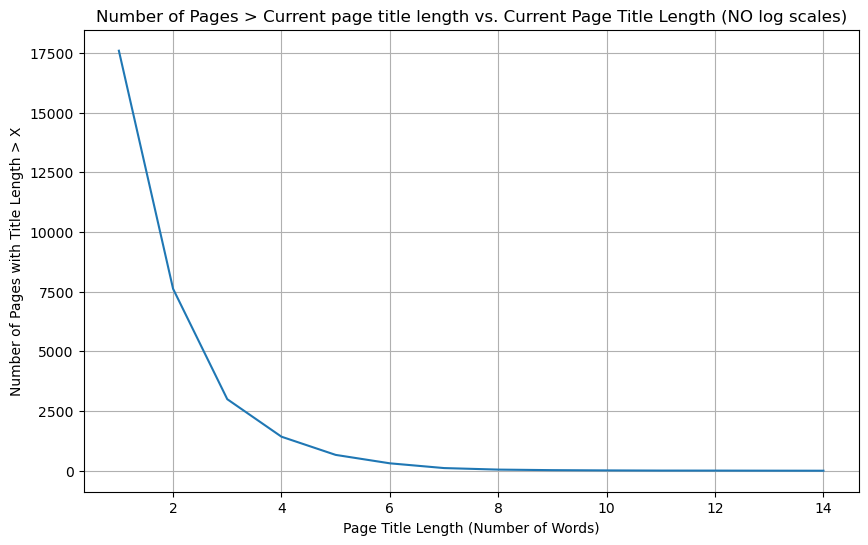

In [40]:
plt.figure(figsize=(10, 6))
plt.plot(x, y)
plt.xlabel("Page Title Length (Number of Words)")
plt.ylabel("Number of Pages with Title Length > X")
plt.title("Number of Pages > Current page title length vs. Current Page Title Length (NO log scales)")
plt.grid(True)
plt.show()

In [41]:
import math
log_x = [math.log(element) for element in x]
y_filtered = [element for element in y if element != 0]
log_y = [math.log(element) for element in y_filtered]

len(log_x)

14

In [42]:
log_y.append(0)
len(log_y)

14

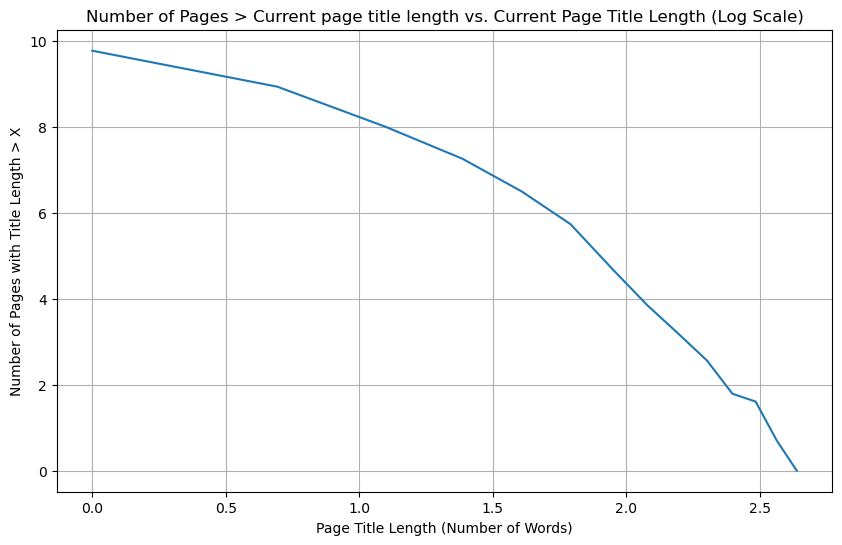

In [43]:
plt.figure(figsize=(10, 6))
plt.plot(log_x, log_y)
plt.xlabel("Page Title Length (Number of Words)")
plt.ylabel("Number of Pages with Title Length > X")
plt.title("Number of Pages > Current page title length vs. Current Page Title Length (Log Scale)")
plt.grid(True)
plt.show()

As we move along the X-axis, we observe that the log of number of pages with a title length greater than the specified length decreases.

We can interpret that shorter titles are definitely more common, which can further be indicative of users being inclined to click on or engage with pages with shorter, more concise titles, leading to a higher prevalence of such pages. We know that the data we are analysing comes from the wikipedia dump dataset, and so, we can also reason that shorter titles may be more favorable for search engine optimization (SEO). Pages with shorter, more relevant titles might rank higher in search engine results, leading to their higher prevalence.

### Content edits over time

We will compute the number of pages per revision timestamp sorted in decreasing order of the number of pages.

In [44]:
from pyspark.sql.functions import year

In [45]:
pages_per_timestamp = df.groupBy("revision_ts").count().orderBy("count", ascending=False) \
                        .show(20)

+-------------------+-----+
|        revision_ts|count|
+-------------------+-----+
|2002-02-25 15:51:15|   70|
|2002-02-25 15:43:11|   29|
|2022-07-24 04:23:37|    8|
|2021-01-04 12:08:13|    7|
|2021-01-04 12:08:11|    6|
|2021-01-04 12:08:14|    5|
|2024-02-19 18:30:13|    5|
|2021-01-04 12:08:12|    5|
|2021-08-31 20:08:13|    5|
|2024-02-17 19:29:35|    4|
|2024-02-07 16:07:10|    3|
|2024-02-19 18:29:01|    3|
|2024-02-19 17:41:52|    3|
|2022-09-24 13:34:32|    3|
|2021-01-04 12:08:15|    3|
|2023-12-21 15:58:20|    3|
|2024-02-04 05:10:21|    2|
|2024-02-16 21:10:22|    2|
|2024-02-18 18:03:20|    2|
|2024-02-15 23:45:24|    2|
+-------------------+-----+
only showing top 20 rows



In [46]:
# Computing the number of pages per year, sorted in increasing order of years.
pages_per_year = df.withColumn("year", year("revision_ts")).groupBy("year").count().orderBy("year") \
                   .show(20)

+----+-----+
|year|count|
+----+-----+
|2002|  238|
|2003|  161|
|2004|  168|
|2005|  186|
|2006|  227|
|2007|  116|
|2008|  130|
|2009|  165|
|2010|  193|
|2011|  125|
|2012|  434|
|2013|   97|
|2014|   91|
|2015|   79|
|2016|  111|
|2017| 1298|
|2018|  376|
|2019|  256|
|2020|  701|
|2021|  591|
+----+-----+
only showing top 20 rows



### P2.4 Number of categories versus text length

In [47]:
#creating a Dataframe from the RDD with two columns, one for page ID and the other for the text length of Wikipedia pages
def new_df(row):
    return (page_id(row), len(row.split()))

In [48]:
my_df = rdd2.map(new_df) \
            .toDF(['page_id', 'text_length']) \
            .orderBy('text_length', ascending=False)
my_df.show(2)

+-------+-----------+
|page_id|text_length|
+-------+-----------+
|  32817|      49974|
|  39582|      49742|
+-------+-----------+
only showing top 2 rows



In [49]:
page_cat_len = df.join(my_df, on='page_id', how='inner')
page_cat_len.show(2)

+-------+-------------+--------------------+--------------------+-------------------+-----------+
|page_id|        title|         contributor|          categories|        revision_ts|text_length|
+-------+-------------+--------------------+--------------------+-------------------+-----------+
|     29|AlbaniaPeople|[{9784415, Tom.Re...|                  []|2017-06-05 04:20:05|         37|
|   1677| Alfonso XIII|  [{2387872, DrKay}]|[Alfonso XIII of ...|2024-02-18 07:55:41|       7376|
+-------+-------------+--------------------+--------------------+-------------------+-----------+
only showing top 2 rows



#### Showing the top 20 rows of the new required dataframe sorted in decreasing order of page text lengths.

In [50]:
num_cat = sql_f.udf(lambda x: len(x), IntegerType())
output = page_cat_len.withColumn('category_count', num_cat(page_cat_len['categories'])) \
                     .orderBy('text_length', ascending=False)
output = output.select('page_id','category_count','text_length')
output.show(20)

+-------+--------------+-----------+
|page_id|category_count|text_length|
+-------+--------------+-----------+
|  32817|            61|      49974|
|  39582|             1|      49742|
|  14604|             2|      44304|
|  39070|            22|      44093|
|  10152|            42|      43668|
|  12686|             4|      43506|
|  13224|             2|      42894|
|  34579|             5|      42804|
|  25074|             5|      42600|
|  26847|             7|      40528|
|  14889|            19|      39429|
|  27034|             7|      39146|
|  18524|             2|      38948|
|  23235|            19|      38586|
|   7023|            15|      38322|
|  14532|            13|      37254|
|  13458|             1|      37221|
|  21217|             8|      36673|
|  13913|            34|      36458|
|  14653|            21|      36380|
+-------+--------------+-----------+
only showing top 20 rows



#### Showing a plot of the number of categories versus the page text length

In [51]:
x = output.select("text_length").rdd.flatMap(lambda x: x).collect()
y = output.select('category_count').rdd.flatMap(lambda x: x).collect()

In [52]:
x[0:20]

[49974,
 49742,
 44304,
 44093,
 43668,
 43506,
 42894,
 42804,
 42600,
 40528,
 39429,
 39146,
 38948,
 38586,
 38322,
 37254,
 37221,
 36673,
 36458,
 36380]

In [53]:
y[0:20]

[61, 1, 2, 22, 42, 4, 2, 5, 5, 7, 19, 7, 2, 19, 15, 13, 1, 8, 34, 21]

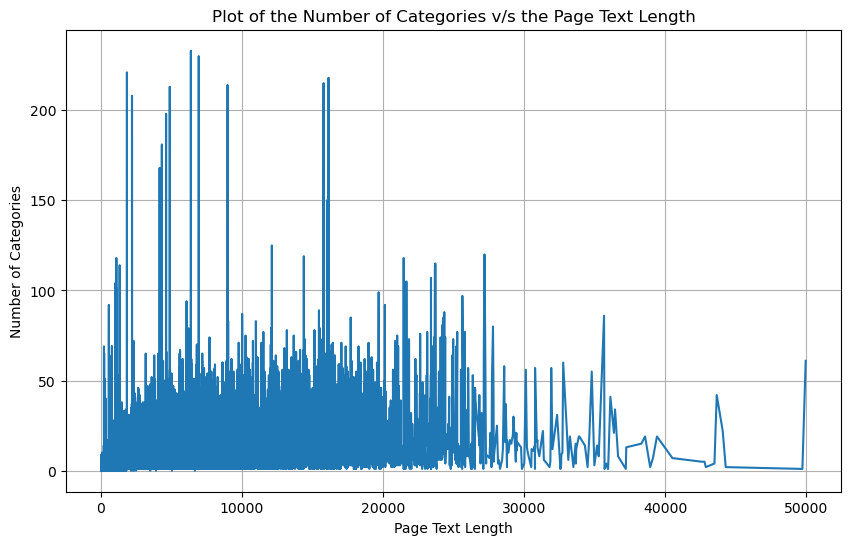

In [54]:
plt.figure(figsize=(10, 6))
plt.plot(x, y)
plt.xlabel("Page Text Length")
plt.ylabel("Number of Categories")
plt.title("Plot of the Number of Categories v/s the Page Text Length")
plt.grid(True)
plt.show()

## P3 Spark SQL and Dataframes

### P3.1 A Spark SQL range query

In [55]:
df.show(10)

+-------+--------------------+--------------------+--------------------+-------------------+
|page_id|               title|         contributor|          categories|        revision_ts|
+-------+--------------------+--------------------+--------------------+-------------------+
|     10| AccessibleComputing|  [{20842734, Elli}]|                  []|2021-01-23 15:15:01|
|     12|           Anarchism|    [{244263, Czar}]|[Anarchism| , Ant...|2024-02-17 15:33:05|
|     13|  AfghanistanHistory|[{9784415, Tom.Re...|                  []|2017-06-05 04:18:18|
|     14|AfghanistanGeography|[{9784415, Tom.Re...|                  []|2017-06-05 04:18:23|
|     15|   AfghanistanPeople|[{9784415, Tom.Re...|                  []|2017-06-05 04:19:42|
|     18|AfghanistanCommun...|[{9784415, Tom.Re...|                  []|2017-06-05 04:19:45|
|     19|AfghanistanTransp...|[{9784415, Tom.Re...|                  []|2017-06-04 21:42:11|
|     20| AfghanistanMilitary|  [{8066546, Xqbot}]|                  [

Creating a temporary view for the Dataframe created before:

In [56]:
df.createOrReplaceTempView('mydata')

Spark SQL query to select top 20 rows which correspond to pages that were revised in January of 2023, ordered by revision time in decreasing order:

In [57]:
spark.sql('''SELECT *
    FROM mydata
    WHERE revision_ts >= '2023-01-01 00:00:00' AND revision_ts < '2023-02-01 00:00:00'
    ORDER BY revision_ts DESC
''').show(20)

+-------+--------------------+--------------------+--------------------+-------------------+
|page_id|               title|         contributor|          categories|        revision_ts|
+-------+--------------------+--------------------+--------------------+-------------------+
|  25296|                Quid|[{40908735, Caleb...|                  []|2023-01-31 22:53:45|
|   5334|Telecommunication...|[{211905, Bruce1ee}]|[Telecommunicatio...|2023-01-31 17:14:34|
|   3681|Telecommunication...|[{211905, Bruce1ee}]|[Telecommunicatio...|2023-01-31 17:13:41|
|   5453|Telecommunication...|[{211905, Bruce1ee}]|[Telecommunicatio...|2023-01-31 17:11:35|
|  27314|Telecommunication...|[{211905, Bruce1ee}]|[Telecommunicatio...|2023-01-31 15:51:17|
|  12192|Telecommunication...|[{211905, Bruce1ee}]|[Telecommunicatio...|2023-01-31 15:41:34|
|  12162|Telecommunication...|[{211905, Bruce1ee}]|[Communications i...|2023-01-31 15:40:43|
|  12033|Telecommunication...|[{211905, Bruce1ee}]|[Telecommunicatio..

Spark SQL query to count the number of pages that were revised in January 2023 and showing the count:

In [58]:
spark.sql('''
    SELECT COUNT(*) AS count
    FROM mydata
    WHERE revision_ts >= '2023-01-01 00:00:00' AND revision_ts < '2023-02-01 00:00:00'
''').show()

+-----+
|count|
+-----+
|  107|
+-----+



### Page Categories

Finding the top 20 rows of distinct categories in df, the number of pages per distinct category, with rows sorted in decreasing order of the second column values:

In [59]:
from pyspark.sql.functions import explode, count, col

In [60]:
df1 = df.select(explode("categories").alias("distinct_category")) 
category_count_df = df1.groupBy('distinct_category').agg(count('*').alias('pages_count'))
sorted_category_count_df = category_count_df.orderBy(col('pages_count').desc())

In [61]:
category_count_df = df1.groupBy('distinct_category').agg(count('*').alias('pages_count')) \
                       .orderBy('pages_count', ascending=False) \
                       .show(20)

+--------------------+-----------+
|   distinct_category|pages_count|
+--------------------+-----------+
|Articles containi...|        616|
|       Living people|        582|
|    Days of the year|        445|
|20th-century Amer...|        193|
|               Popes|        165|
|Year of birth unk...|        154|
|Member states of ...|        137|
|20th-century Amer...|        128|
|American male nov...|        117|
|Members of the Am...|        117|
|American male non...|        114|
|       Italian popes|        111|
|American people o...|        110|
|American male fil...|        107|
|20th-century Amer...|        106|
|Fellows of the Am...|        104|
|Leap years in the...|        102|
|Fellows of the Ro...|        101|
| American inventions|        101|
|Grammy Award winners|        100|
+--------------------+-----------+
only showing top 20 rows



Spark SQL query to count the number of pages per category and showing the results in decreasing order of this count:

In [62]:
df2 = df.select(col("page_id").alias('pid'), explode(col("categories")).alias("cat"))
df2.createOrReplaceTempView("wiki_cat")

In [63]:
df2.show()

+---+--------------------+
|pid|                 cat|
+---+--------------------+
| 12|         Anarchism| |
| 12|     Anti-capitalism|
| 12|        Anti-fascism|
| 12| Economic ideologies|
| 12|   Far-left politics|
| 12|  Left-wing politics|
| 12|Libertarian socia...|
| 12|      Libertarianism|
| 12|   Political culture|
| 12|Political ideologies|
| 12| Political movements|
| 12|     Social theories|
| 12|           Socialism|
| 25|    1910s neologisms|
| 39|Land surface effe...|
| 39|Climate change fe...|
| 39|     Climate forcing|
| 39|         Climatology|
| 39|Electromagnetic r...|
| 39|Meteorological qu...|
+---+--------------------+
only showing top 20 rows



In [64]:
spark.sql('''
    SELECT cat, COUNT(DISTINCT pid) AS page_count
    FROM wiki_cat
    GROUP BY cat
    ORDER BY page_count DESC
'''
).show()

+--------------------+----------+
|                 cat|page_count|
+--------------------+----------+
|Articles containi...|       616|
|       Living people|       582|
|    Days of the year|       355|
|20th-century Amer...|       193|
|               Popes|       165|
|Year of birth unk...|       154|
|Member states of ...|       137|
|20th-century Amer...|       128|
|Members of the Am...|       117|
|American male nov...|       117|
|American male non...|       114|
|       Italian popes|       111|
|American people o...|       110|
|American male fil...|       107|
|20th-century Amer...|       106|
|Fellows of the Am...|       104|
|Leap years in the...|       102|
| American inventions|       101|
|Fellows of the Ro...|       101|
|Grammy Award winners|       100|
+--------------------+----------+
only showing top 20 rows



### Saving a table

In [71]:
from pyspark.sql.functions import year, month

In [72]:
save_tab = df.withColumn('ts_year', year('revision_ts')) \
            .withColumn('ts_month', month('revision_ts'))

In [73]:
save_tab.write.mode("overwrite").partitionBy("ts_year", "ts_month").saveAsTable("wikipersisted")

In [74]:
save_tab = spark.read.table("wikipersisted")

In [75]:
save_tab.show(20)

+-------+--------------------+--------------------+--------------------+-------------------+-------+--------+
|page_id|               title|         contributor|          categories|        revision_ts|ts_year|ts_month|
+-------+--------------------+--------------------+--------------------+-------------------+-------+--------+
|  15665|  Economy of Jamaica|[{372290, Nikkima...|[Economy of Jamai...|2024-02-02 00:46:55|   2024|       2|
|  15673|           Jan Mayen|[{27015025, Inter...|[Jan Mayen| , 161...|2024-02-11 02:10:03|   2024|       2|
|  15683|       Jarvis Island|[{35936988, JJMC8...|[Jarvis Island| ,...|2024-02-10 22:34:30|   2024|       2|
|  15696|Demography of Jersey|[{17216044, RMCD ...|[Demographics of ...|2024-02-01 02:37:20|   2024|       2|
|  15697|  Politics of Jersey|[{7611264, Anomie...|[Politics of Jers...|2024-02-07 11:25:22|   2024|       2|
|  15698|   Economy of Jersey|[{25082147, Mazew...|[Economy of Jerse...|2024-02-13 18:05:45|   2024|       2|
|  15704| 

In [76]:
spark.sql("DESCRIBE EXTENDED wikipersisted;").show()

+--------------------+--------------------+-------+
|            col_name|           data_type|comment|
+--------------------+--------------------+-------+
|             page_id|              bigint|   null|
|               title|              string|   null|
|         contributor|array<struct<cont...|   null|
|          categories|       array<string>|   null|
|         revision_ts|           timestamp|   null|
|             ts_year|                 int|   null|
|            ts_month|                 int|   null|
|# Partition Infor...|                    |       |
|          # col_name|           data_type|comment|
|             ts_year|                 int|   null|
|            ts_month|                 int|   null|
|                    |                    |       |
|# Detailed Table ...|                    |       |
|            Database|             default|       |
|               Table|       wikipersisted|       |
|               Owner|                root|       |
|        Cre

The output of spark.sql("DESCRIBE EXTENDED wikipersisted;") can be explained as follows:

Column Information:
- col_name: Name of the column
- data_type: Data type of the column
- comment: Any additional comments or descriptions about the column

We can also see # Partition Information. In this case, the table is partitioned by the column names ts_year and ts_month.

We can also see # Detailed Table... (Information) which provides detailed information about the table itself, including its database, owner, creation time, access time, type, location, provider (e.g., parquet), serde library, input and output formats, and partition provider.